# Transform Biot Savart law to calculation of the Elliptic Integral

<img align="right" width="45%" src="figures/StabScheme.jpg">
<font size="3.5">
<br> 
<p style="text-align: justify">Alternative method to speed up the calculation time of magnetic field from single turn toroidal loop is to use Legendre's complete elliptic integrals of the first and second kind K(k) and E(k) for parameter k to solve the Biot-Savart law. The numerical solution is then:</p>

- $B_r=\frac{\mu_0 I}{4\pi}\frac{(Z_0-Z_1)f_1(k)}{R_1\sqrt{R_0R_1}} $
 
- $B_z=\frac{\mu_0 I}{4\pi}\frac{R_1f_1(k)+R_0f_2(k)}{R_1\sqrt{R_0R_1}} $

- $k^2=\frac{4R_0R_1}{(R_0+R_1)^2+(Z_1-Z_0)^2}$

- $f_1(k)=k(K(k)-\frac{2-k^2}{2(1-k^2)}E(k))$

- $f_2(k)=\frac{k^3}{2(1-k^2)}E(k)$

<br>    
<br>        
<br>        
    
There are two possibility how to numericlly calculate elliptic integral. One possibility is to use iterative method described in [Calrslon, Numerical Algorithms](http://arxiv.org/pdf/math/9409227.pdf). Another possibility are polynomial approximations for complementary parameter m1 from [Abrahamowitz, Mathematical Functions with Formulas](http://www.pdmi.ras.ru/~lowdimma/BSD/abramowitz_and_stegun.pdf) (Page 232, Chapter 17). We will use the second one.
</font>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
ds = np.DataSource(destpath='')
from scipy import integrate, signal, interpolate
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3
import requests
from urllib.request import urlopen
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
perm = 4e-7*np.pi
def k_func(R0, R1,Z0,Z1):
    k=4*R0*R1/((R0+R1)**2+((Z1-Z0)**2))
    return np.sqrt(k)


from scipy.special import ellipk, ellipe, ellipkm1
def K(k):
    m1=1-(k**2)
    a=np.zeros((2,5))
    a[0][0] = 1.38629436112
    a[0][1] = 0.09666344259
    a[0][2] = 0.03590092383
    a[0][3] = 0.03742563713
    a[0][4] = 0.01451196212
    
    a[1][0] = 0.5
    a[1][1] = 0.12498593597
    a[1][2] = 0.06880248576
    a[1][3] = 0.03328355346
    a[1][4] = 0.00441787012
    
    K=a[0][0]+m1*(a[0][1]+m1*(a[0][2]+m1*(a[0][3]+m1*a[0][4])))+a[1][0]+m1*(a[1][1]+m1*(a[1][2]+m1*(a[1][3]+m1*a[1][4])))*np.log(1/m1)
    
    return K
#     return ellipk(k)

def E(k):
    m1=1-(k**2)
    a=np.zeros((2,4))
    a[0][0] = 0.44325141463
    a[0][1] = 0.06260601220
    a[0][2] = 0.04757383546
    a[0][3] = 0.01736506451
    
    a[1][0] = 0.24998368310
    a[1][1] = 0.09200180037
    a[1][2] = 0.04069697526
    a[1][3] = 0.00526449639
    
    E = 1+m1*(a[0][0]+m1*(a[0][1]+m1*(a[0][2]+m1*a[0][3])))+m1*(a[1][0]+m1*(a[1][1]+m1*(a[1][2]+m1*a[1][3])))*np.log(1/m1)
    return E
#     return ellipe(k)

def f1(k):
    f1=k*(K(k)-(2-(k**2)*E(k))/(2*(1-(k**2))))
    return f1

def f2(k):
    f2=(k**3)*E(k)/(2*(1-(k**2)))
    return f2

def B_loop(R1,Z1,CoilPos=[0.65,0,-0.24],I=1000, Ior=1):    
    R0=CoilPos[0]
    Z0=CoilPos[2]
    k=k_func(R0,R1,Z0,Z1)
    konst=perm*I/(4*np.pi)
    Br=konst*(Z0-Z1)*f1(k)/(R1*np.sqrt(R0*R1))
    Bz=konst*(R1*f1(k)+R0*f2(k))/(R1*np.sqrt(R0*R1))
    return Br, Bz

def B_windings(x,z,Stab='HorStab',I=1000, Ior=1,N=4):
    if Stab== 'HorStab':
#         CoilsPos=np.asarray([[[0.65,0,-0.2],[0.65,0,0.2],[0.21,0,0.29],[0.21,0,-0.29]],[1,1,-1,-1]],dtype='object')
        CoilsPos=np.array([[[0.65,0,-0.257],[0.65,0,0.233],[0.21,0,0.28],[0.21,0,-0.28]],[1,1,-1,-1]],dtype='object')#new position
    elif Stab=='VerStab':
#         CoilsPos=np.asarray([[[0.65,0,-0.18],[0.65,0,0.18],[0.29,0,0.26],[0.29,0,-0.26]],[1,-1,-1,1]],dtype='object')
        CoilsPos=np.array([[[0.65,0,-0.233],[0.65,0,0.257],[0.27,0,0.28],[0.27,0,-0.28]],[1,-1,-1,1]],dtype='object')
    elif Stab=='InnerStab':
        CoilsPos=np.asarray([[[0.483,0,-0.083],[0.483,0,0.083],[0.327,0,0.083],[0.327,0,-0.083]],[1,1,-1,-1]],dtype='object')    
    NumCoil=4
    Br_wind=0
    Bz_wind=0
    for coil in range(NumCoil):
        Ior=CoilsPos[1][coil]
        Br,Bz=B_loop(x,z,CoilsPos[0][coil],I,Ior)
        Br_wind+=Br*N*Ior
        Bz_wind+=Bz*N*Ior     
    return Br_wind,Bz_wind

In [3]:
def B_1D(Coord,Stab='HorStab',I=100,N=8):
    B=np.zeros((2,Coord.shape[0]))
    for i in range(Coord.shape[0]):
        B[0][i],B[1][i]=B_windings(Coord[i][0],Coord[i][2],Stab=Stab,I=I,N=N)
    return B
    
def B_1D_loop(Coord,Stab='HorStab',Coil=1,I=1000):
    B=np.zeros((2,Coord.shape[0]))
    if Stab== 'HorStab':
#         CoilsPos=np.asarray([[[0.65,0,-0.2],[0.65,0,0.2],[0.21,0,0.29],[0.21,0,-0.29]],[-1,-1,1,1]])
        CoilsPos=np.array([[[0.65,0,-0.257],[0.65,0,0.233],[0.21,0,0.28],[0.21,0,-0.28]],[-1,-1,1,1]],dtype='object')   
    elif Stab=='VerStab':
#         CoilsPos=np.asarray([[[0.65,0,-0.18],[0.65,0,0.18],[0.29,0,0.29],[0.29,0,-0.29]],[1,-1,-1,1]])
        CoilsPos=np.array([[[0.65,0,-0.233],[0.65,0,0.257],[0.27,0,0.28],[0.27,0,-0.28]],[1,-1,-1,1]],dtype='object')
    elif Stab=='Example':
        CoilsPos=np.array([[[0.235,0,0.0]],[1]])
        
    for i in range(Coord.shape[0]):
        B[0][i],B[1][i]=B_loop(Coord[i][0],Coord[i][2],CoilsPos[0][Coil],I=I,Ior=CoilsPos[1][Coil])
    return B    

def mc_sim(identifier,Stab='HorStab',I=1000):
    df=pd.DataFrame({'mc1':[0.493,0,0],'mc5':[0,0,0.093],'mc9':[0.307,0,0],'mc13':[0,0,-0.093]}, index=['x','y','z'])
    r=df[identifier].values
    tspan=I.index
    mc=np.zeros((2,len(tspan)))
    for i in range(len(tspan)):
        mc[0][i],mc[1][i]=B_windings(r,Stab=Stab,I=I.iat[i])
    return mc


### Magnetic field on the line crossing vacuum vessel (1D)

In [4]:
def create_coord(x=np.arange(0,0.6,0.1),z=np.arange(-0.3,0.3,0.1)):
    Coord=np.zeros((len(x),3))
    for i in range(len(x)):
        Coord[i][0]=x[i]
        Coord[i][2]=z[i]
    return Coord
##along x-axis
x=np.arange(0.2,0.6,0.01)
# z=np.zeros((len(x)))
z=np.full((len(x)),0.0)
##along z-axis
z2=np.arange(-0.3,0.3,0.01)
x2=np.full((len(z2)),0.4)

VertLine=create_coord(x,z) #vertical line
HorLine=create_coord(x2,z2) #horizontal line
B_hor_vl=B_1D(VertLine,Stab='HorStab')
B_hor_hl=B_1D(HorLine,Stab='HorStab')
B_ver_hl=B_1D(HorLine,Stab='VerStab')
B_ver_vl=B_1D(VertLine,Stab='VerStab')
B_inner_hl=B_1D(HorLine,Stab='InnerStab',N=1)
B_inner_vl=B_1D(VertLine,Stab='InnerStab',N=1)
Data_vl=pd.DataFrame(data= {f'x (z={z[0]})': x, 'Bz_horStab_vl': B_hor_vl[1],'Br_verStab_vl': B_ver_vl[0], 
                            'Bz_innerQuadr_vl': B_inner_vl[1]})
Data_hl=pd.DataFrame(data= {f'z (x={x2[0]})': z2, 'Bz_horStab_hl': B_hor_hl[1],'Br_verStab_hl': B_ver_hl[0],
                           'Bz_innerQuadr_hl': B_inner_hl[1]} )
Data=pd.concat([Data_vl,Data_hl],ignore_index=True)
display(Data_vl.loc[15:40])
# B=B_1D_loop(coord,Stab='HorStab', Coil=1)


,x (z=0.0),Bz_horStab_vl,Br_verStab_vl,Bz_innerQuadr_vl
15,0.35,0.001025,0.000706,0.000347
16,0.36,0.001039,0.000728,0.000393
17,0.37,0.001050,0.000750,0.000428
18,0.38,0.001059,0.000770,0.000452
19,0.39,0.001065,0.000789,0.000466
20,0.40,0.001069,0.000809,0.000471
21,0.41,0.001071,0.000828,0.000468
22,0.42,0.001070,0.000847,0.000456
23,0.43,0.001067,0.000867,0.000436
24,0.44,0.001061,0.000887,0.000406


In [5]:
# x_ex=np.arange(-0.3,0.3,0.01)
# # z=np.zeros((len(x)))
# z=np.full((len(x)),0.0)
# # z=np.zeros((len(x)))
# z_ex=np.full((len(x_ex)),0.0)
# coord_ex=create_coord(x_ex,z_ex)
# B_loop_try=B_1D_loop(coord_ex,Stab='Example',Coil=0,I=1)

# data=pd.DataFrame(data={'x': x_ex,'Loop Br': B_loop_try[0]*1e6, 'Loop Bz': B_loop_try[1]*1e6})
# data.loc[30:40]

In [6]:
# plt.plot(x_ex,B_loop_try[1]*1e6,'rx')

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

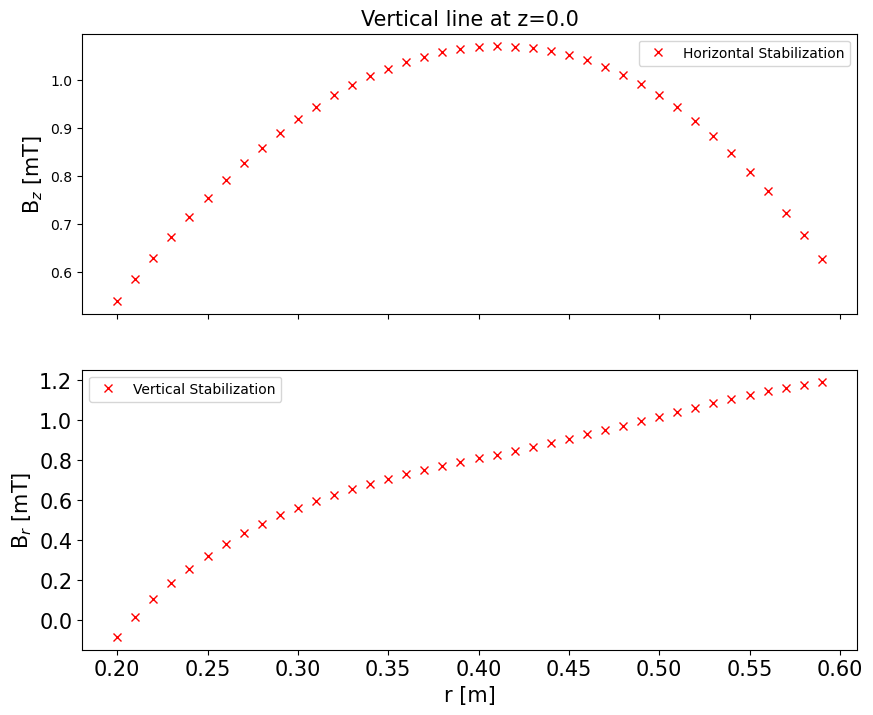

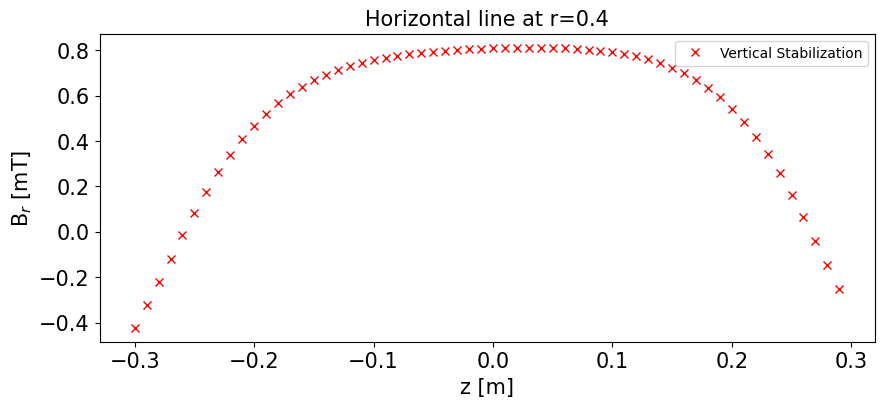

In [7]:
kw=dict(fontname='DejaVu Sans', fontsize=15)#, fontweight='bold')
fig,ax=plt.subplots(2,1, figsize=(10,8),sharex=True)
ax[0].plot(x,B_hor_vl[1]*1e3,'rx', label='Horizontal Stabilization')
plt.yticks(**kw)
ax[1].plot(x,B_ver_vl[0]*1e3,'rx',label = 'Vertical Stabilization')
for i in range(2):
    ax[i].legend()
    ax[i].set_ylabel('B$_z$ [mT]',**kw)   
ax[1].set_ylabel('B$_r$ [mT]',**kw)
ax[0].set_title(f'Vertical line at z={z[0]}',**kw)
ax[1].set_xlabel('r [m]',**kw)
plt.yticks(**kw)
plt.xticks(**kw)
 
fig2,ax=plt.subplots(1,1, figsize=(10,4))
ax.plot(z2,B_ver_hl[0]*1e3,'rx',label = 'Vertical Stabilization')
ax.set_title(f'Horizontal line at r={x2[0]}',**kw)
ax.set_ylabel('B$_r$ [mT]',**kw) 
ax.set_xlabel('z [m]',**kw)
ax.legend()
plt.xticks(**kw)
plt.yticks(**kw)

In [8]:
# ##along x-axis
# x=np.arange(0.1,0.6,0.01)
# # z=np.zeros((len(x)))
# z=np.full((len(x)),0.290)
# ##along z-axis
# z2=np.arange(-0.3,0.3,0.01)
# x2=np.full((len(z2)),0.4)

# VertLine=create_coord(x,z) #vertical line
# HorLine=create_coord(x2,z2) #horizontal line

# I=102
# B_hor_vl_loop=B_1D_loop(VertLine,Stab='HorStab',Coil=1,I=I)
# B_ver_vl_loop=B_1D_loop(VertLine,Stab='VerStab',Coil=1,I=I)
# B_ver_hl_loop=B_1D_loop(HorLine,Stab='VerStab',Coil=1,I=I)

# B_loop_try=B_1D_loop(VertLine,Stab='Example',Coil=0,I=I)
# data=pd.DataFrame(data={'x': x,'Loop Br': B_loop_try[0]*1e3, 'Loop Bz': B_loop_try[1]*1e3})
# data.loc[20:40]
# plt.plot(x,B_loop_try[0]*1e3,'rx')

In [9]:
# # %matplotlib
# fig,ax=plt.subplots(2,1, figsize=(10,8),sharex=True)
# ax[0].plot(x,B_hor_vl_loop[1]*1e3,'rx', label='Horizontal Stabilization')
# plt.yticks(**kw)
# ax[1].plot(x,B_ver_vl_loop[0]*1e3,'rx',label = 'Vertical Stabilization')
# for i in range(2):
#     ax[i].legend()
#     ax[i].set_ylabel('B$_z$ [mT]',**kw)   
# ax[1].set_ylabel('B$_r$ [mT]',**kw)
# ax[0].set_title(f'Vertical line at z={z[0]}',**kw)
# ax[1].set_xlabel('r [m]',**kw)
# plt.yticks(**kw)
# plt.xticks(**kw)

# fig2,ax=plt.subplots(1,1, figsize=(10,4))
# ax.plot(z2,B_ver_hl_loop[0]*1e3,'rx',label = 'Vertical Stabilization')
# ax.set_title(f'Horizontal line at r={x2[0]}',**kw)
# ax.set_ylabel('B$_r$ [mT]',**kw) 
# ax.set_xlabel('z [m]',**kw)
# ax.legend()
# plt.xticks(**kw)
# plt.yticks(**kw)

### Magnetic field spatially (2D/3D)

In [10]:
FONT='DejaVu Sans'
I=100
x = np.arange(0.18, 0.6, 0.015)
# x = np.arange(0.3, 0.5, 0.015)
z = np.arange(-0.2, 0.2, 0.015)
# z = np.arange(-0.1, 0.1, 0.015)
xx, zz = np.meshgrid(x, z, sparse=True)
b_hor=B_windings(xx,zz,'HorStab',I=I,N=8)

b_ver=B_windings(xx,zz,'VerStab',I=I,N=8)

X, Z = np.mgrid[0.32:0.49:15j, -0.09:0.09:15j]
b_inner=B_windings(X,Z,'InnerStab',I=I,N=1)

Stab=np.array([b_hor,b_ver])

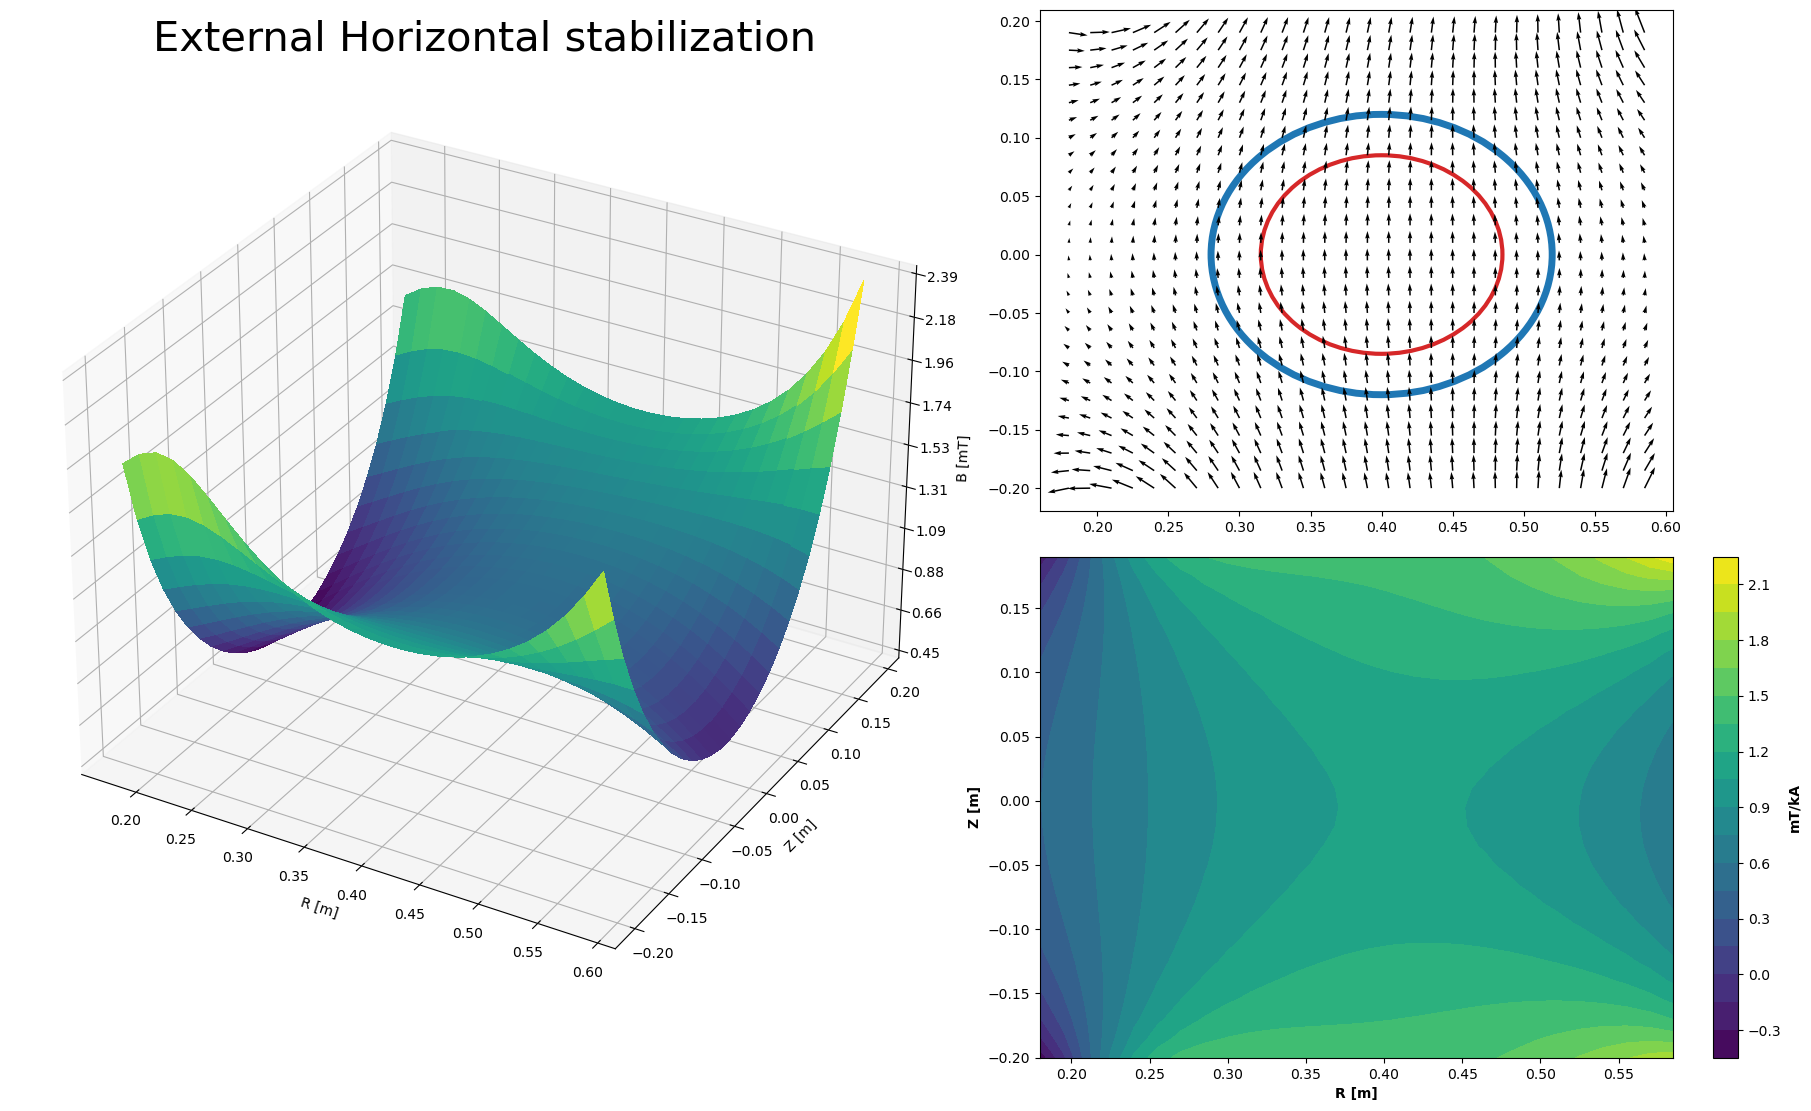

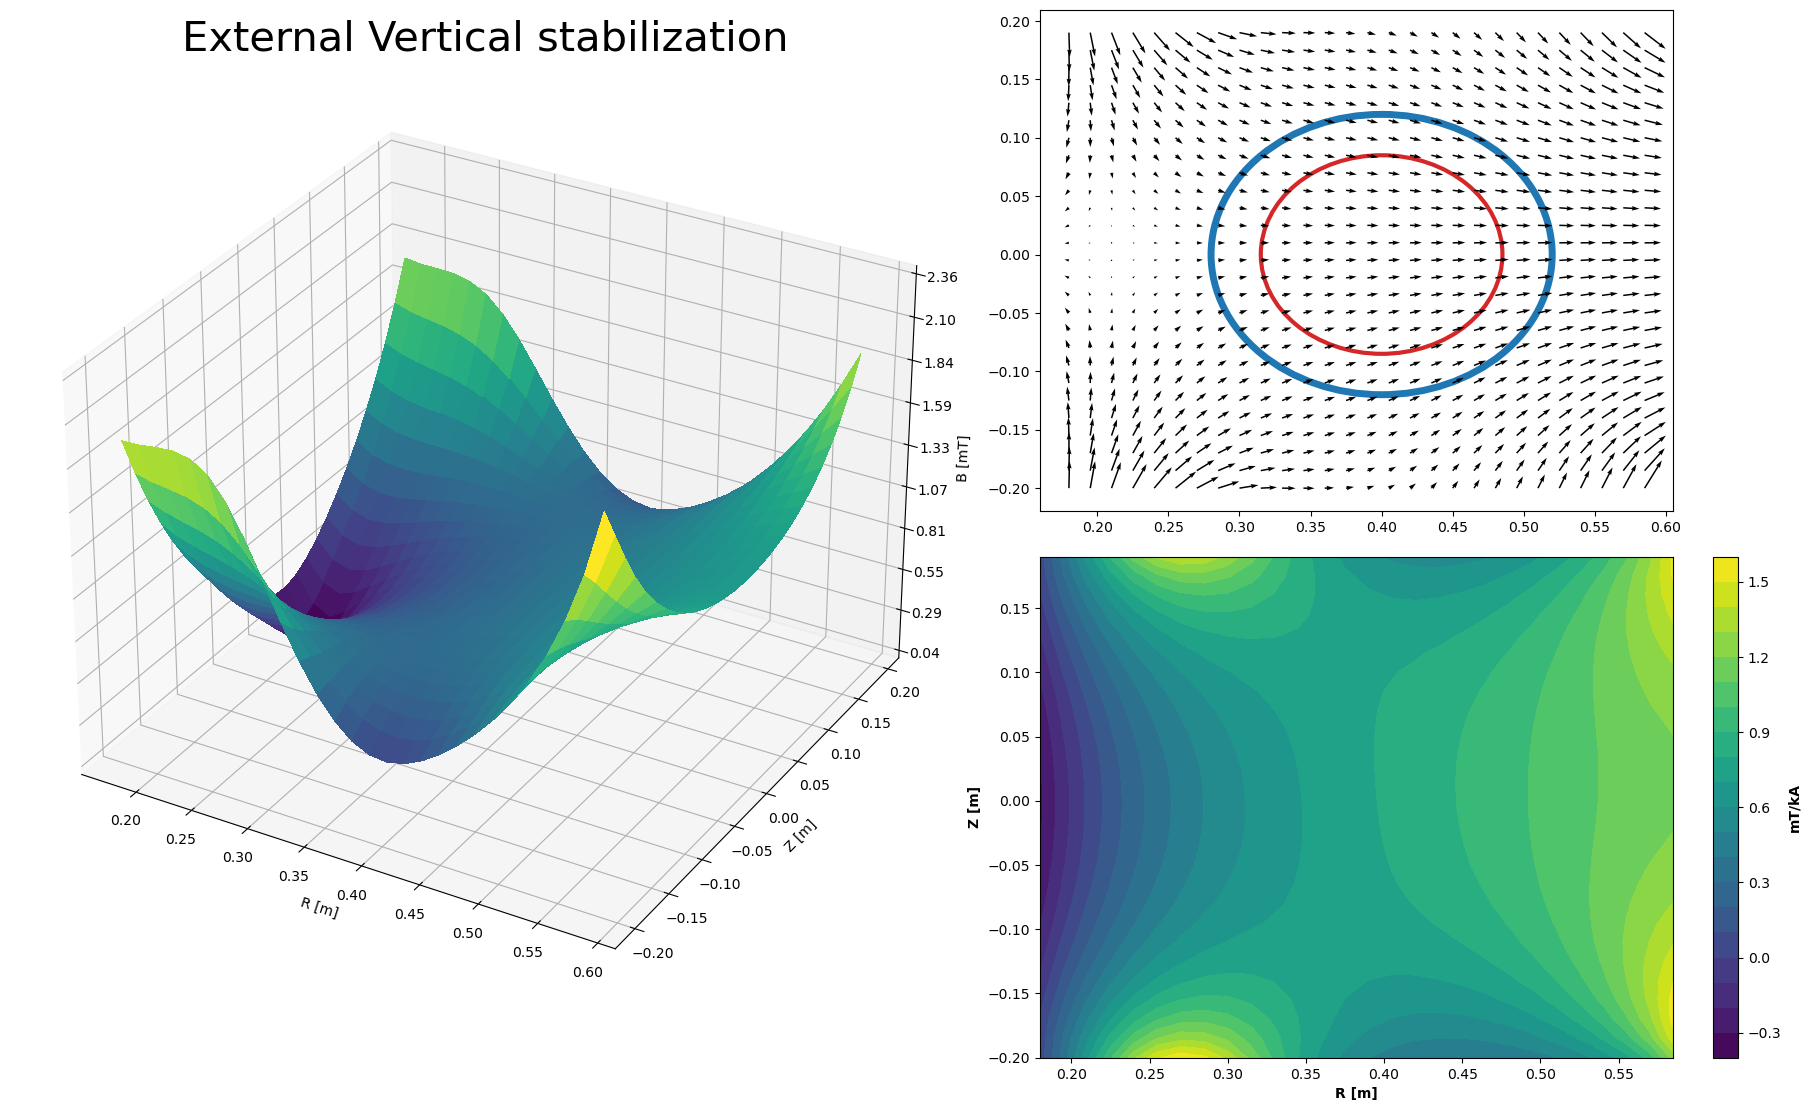

In [11]:
# %matplotlib
for stab in Stab:
    i=1
    title='External Horizontal stabilization'
    if np.all(stab==b_ver):
        i=0
        title='External Vertical stabilization'
    fig = plt.figure(figsize = (18,11), constrained_layout=True)
    gs = plt.GridSpec(2, 5, figure=fig)
    ax3 = fig.add_subplot(gs[0:,:3],projection='3d')
    ax1 = fig.add_subplot(gs[0,3:])
    ax2 = fig.add_subplot(gs[1,3:])

    vessel = plt.Circle((0.4, 0), 0.120, color='tab:blue', fill = False, lw = 5)
    limiter = plt.Circle((0.4, 0), 0.085, color='tab:red', fill = False, lw = 3)
    ax1.add_artist(limiter)
    ax1.add_artist(vessel)
    q = ax1.quiver(xx,zz,stab[0],stab[1])

#     img = ax2.contourf(x,z,np.sqrt(stab[0]**2+(stab[1]**2))*1e3,levels=20)
    img = ax2.contourf(x,z,stab[i]*1e3,levels=20)
    cb = plt.colorbar(img)
#     plt.clabel(img, inline=True,fontsize=10)
    kw=dict(fontname=FONT, fontsize=10, fontweight='bold')
    ax2.set_xlabel('R [m]',**kw )
    ax2.set_ylabel('Z [m]', **kw)
    cb.set_label('mT/kA',**kw)

    surf = ax3.plot_surface(xx, zz, np.sqrt(stab[0]**2+(stab[1]**2))*1e3, cmap='viridis',linewidth=0, antialiased=False)
    ax3.set_zlabel('B [mT]')
    ax3.set_xlabel('R [m]')
    ax3.set_ylabel('Z [m]')
    ax3.zaxis.set_major_locator(LinearLocator(10))
    ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax3.set_title(title,fontsize=30)

TypeError: gca() got an unexpected keyword argument 'projection'

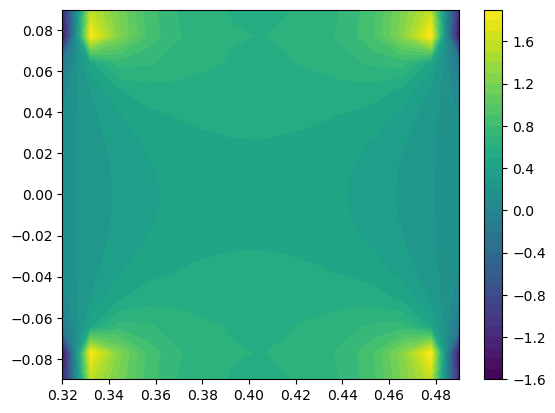

<Figure size 640x480 with 0 Axes>

In [12]:
cp = plt.contourf(X, Z, b_inner[1]*1e3,levels=40)
# plt.clabel(cp, inline=True, fontsize=10)
cb = plt.colorbar(cp)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Z, np.sqrt(b_inner[0]**2+(b_inner[1]**2))*1e3, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots()
q = ax.quiver(X,Z,b_inner[0],b_inner[1])
limiter = plt.Circle((0.4, 0), 0.085, color='tab:red', fill = False, lw = 3)
ax.add_artist(limiter)

### Force acting on the plasma:

We need to discretize plasma into small elements and calculate force acting on these elements at given position:
$F_j=2 \pi  r_j I_j B_r$


In [ ]:
def discretize_plasma(ElShape=[10,10],I=2500, a=0.085,r=0.4,z=0):
    S=np.pi*(a**2)
    NumEl=ElShape[0]*ElShape[1]
    dS=S/NumEl
    dI=I/NumEl
    x=np.linspace(r-a, r+a, ElShape[0])
#     z=np.linspace(z-a, z+a, ElShape[1])
    z=np.full((len(x)),0)
    xx, zz = np.meshgrid(x, z, sparse=True)
    r=np.array([x,z])
    return dI,NumEl,xx,zz

def Force(a=0.085,I=5000):
    dI,Nm,x,z=discretize_plasma(I=I) 
    B=B_windings(x,z,'HorStab',I=500)
    dS=np.pi*(a**2)/Nm
    r=np.sqrt(dS/np.pi)
    F=2*np.pi*r*dI*B[1]
    return F

dI,Nm,x,z=discretize_plasma(I=150000)  
F=Force()
np.sum(F),dI,F



### Toroidal magnetic field

$B_\phi (0,y_0,z_0) =\frac{\mu_0I}{4\pi} \sum^{N_i,N_j,N_k}_{i,j,k} \frac{2\pi a_k(a_k\sin{\theta_i}-z_0)\sin{\theta_i} \cos{\phi_j}+[(R_0+a_k\cos{\theta_i})\cos{\phi_j}-y_0]\cos{\theta_i}}{N_i[(R_0+a_k\cos{\theta_i})^2\sin{\phi_j}+(y_0-(R_0+a_k\cos{\theta_i})\cos{\phi_j})^2+(z_0-a_k\sin{\theta_i})^2]^\frac{3}{2}}$

where $\theta_i$ is i-th element of poloidal angle; $\phi_j=2\pi\frac{j}{N_j}+\phi_0$,where $\phi_0=2\pi \frac{0.5}{N_j}$ and $a_k \in (0.1670, 0.1704)m$.
$N_k=8$, $N_j=28$, $N_i\sim 10^2$

In [ ]:
from numpy import sin, cos, pi
Nj=28
Nk=8
Ni=100
R0=0.4
phi_0=2*pi*0.5/Nj

def dB_tor(i,j,k,y0,z0):    
    a_k=0.167+k*((0.1704-0.1670)/Nk)
    phi_j=2*pi*j/Nj+phi_0
    theta_i=2*pi*i/Ni
    a=2*pi*a_k*(a_k*sin(theta_i)-z0)*sin(theta_i)*cos(phi_j)+((R0+a_k*cos(theta_i))*cos(phi_j)-y0)*cos(theta_i)
    b=((R0+a_k*cos(theta_i))**2)*sin(phi_j)+((y0-(R0+a_k*cos(theta_i))*cos(phi_j))**2)+((z0-a_k*sin(theta_i))**2)
    if np.all(b>0):
        dB=a/(Ni*(b**(3/2)))
    else:
        dB=0
#     print(f'a_k={a_k}, k={k}')
    return dB

def B_tor(y,z,I=1000):
    y0=y
    z0=z
    B_t=dB_tor(0,0,0,y0,z0)
    for i in range(Ni):
        for j in range(1,Nj-1):
            for k in range(Nk):
                dB=dB_tor(i,j,k,y0,z0)
                if not np.isnan(np.sum(dB)):
                    B_t+=dB
#                     print ('dB',dB)
#                 else:
#                     print(dB)
#                     print(f'NaN value in loop: i={i}, j={j}, k={k}')
    B_t*=perm*(1)*I/(4*pi)
    return B_t


y = np.arange(-0.81, 0.8, 0.035)
z = np.arange(-0.21, 0.21, 0.015)
yy, zz = np.meshgrid(y, z, sparse=True)
b_tor=B_tor(yy,zz)
# dB_tor(2,2,3,yy,zz)
# b_tor

z0=0
y0=0.3
for i in range(Ni):
        for j in range(22,Nj):
            for k in range(Nk):
                a_k=0.167+k*((0.1704-0.1670)/Nk)
                phi_j=2*pi*j/Nj+phi_0
                theta_i=2*pi*i/Ni
                phi_j=2*pi*j/Nj+phi_0
                a=2*pi*a_k*(a_k*sin(theta_i)-z0)*sin(theta_i)*cos(phi_j)+((R0+a_k*cos(theta_i))*cos(phi_j)-y0)*cos(theta_i)
                b=((R0+a_k*cos(theta_i))**2)*sin(phi_j)+((y0-(R0+a_k*cos(theta_i))*cos(phi_j))**2)+((z0-a_k*sin(theta_i))**2)
#                 print(f'i={i},j={j},\nb={b}')

In [ ]:
# %matplotlib
cp = plt.contourf(y, z, b_tor,levels=250)
plt.clabel(cp, inline=True, fontsize=10)
cb = plt.colorbar(cp)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(yy, zz, b_tor, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Analytical solution:

$B_\phi (R)=N_jN_k\frac{\mu_0I_c}{2\pi R}$

In [ ]:
def Bt_analytical(r,I=1000):
    B=Nj*Nk*perm*I/(2*pi*r)
    return B

r=np.arange(0.3,0.5,0.01)
z=np.full((len(r)),0.08)
Bt=Bt_analytical(r)
plt.plot(r,Bt)


# Bt_num=np.zeros(len(r))
# for i in range(len(r)):
#     Bt_num[i]=B_tor(r[i],z[i])
# plt.plot(r,Bt_num,'x')
# plt.ylim(0,0.16)